In [1]:
import os 
import sys 
sys.path.append("../training")
import pickle
import copy
import time

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

# Local imports
from transition_labeler import TransitionLabeler

In [2]:
START_WINDOW = 0
END_WINDOW = 770
VAL_SPLIT = 0.3

DATA_IN_DIR = f'../data/raw-data'
DATA_OUT_DIR = f'../data/qick_data/{START_WINDOW}_{END_WINDOW}'
MODEL_DIR = f'models/model_{START_WINDOW}_{END_WINDOW}'

# load data
X_tv = np.load(os.path.join(DATA_OUT_DIR, 'X_train.npy')).astype(np.float32)
X_test = np.load(os.path.join(DATA_OUT_DIR, 'X_test.npy')).astype(np.float32)  
y_tv = np.load(os.path.join(DATA_OUT_DIR, 'y_train.npy')).astype(np.float32)
y_test = np.load(os.path.join(DATA_OUT_DIR, 'y_test.npy')).astype(np.float32)

# Shuffle train-val
tv_shuffler = np.random.permutation(range(X_tv.shape[0]))
X_tv = X_tv[tv_shuffler]
y_tv = y_tv[tv_shuffler]

# Train-val split
X_train = X_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]
y_train = y_tv[:int((1-VAL_SPLIT)*X_tv.shape[0])]

X_val = X_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]
y_val = y_tv[int((1-VAL_SPLIT)*X_tv.shape[0]):]

assert(X_val.shape[0]+X_train.shape[0]==X_tv.shape[0])

In [3]:
labeler = TransitionLabeler()

labeler.fit(X_train, y_train)
y_test_prime = labeler.label(X_test, y_test)

0 = |0>, 1 = |1>, 2 = excitation-error, 3 = relaxation-error


In [4]:
idx0 = np.where(y_test_prime==0)[0]
idx1 = np.where(y_test_prime==1)[0]
idx2 = np.where(y_test_prime==2)[0]
idx3 = np.where(y_test_prime==3)[0]

X_I, X_Q = labeler.split_and_time_average(X_test)

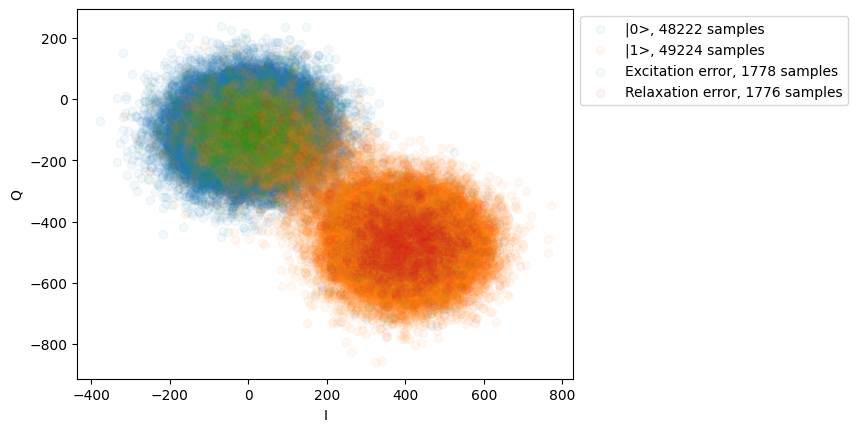

In [5]:
plt.figure()
plt.scatter(X_I[idx0], X_Q[idx0], label = f"|0>, {len(idx0)} samples", alpha=0.05)
plt.scatter(X_I[idx1], X_Q[idx1], label = f"|1>, {len(idx1)} samples", alpha=0.05)
plt.scatter(X_I[idx2], X_Q[idx2], label = f"Excitation error, {len(idx2)} samples", alpha=0.05)
plt.scatter(X_I[idx3], X_Q[idx3], label = f"Relaxation error, {len(idx3)} samples", alpha=0.05)
plt.xlabel("I")
plt.ylabel("Q")
plt.legend(bbox_to_anchor = [1,1])